In [2]:
import sqlite3
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [ ]:
# Export nfl.db to csv files

db_path = 'nfl.db'  # Update this path if needed
conn = sqlite3.connect(db_path)
tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = conn.execute(tables_query).fetchall()
for table in tables:
    table_name = table[0]
    # Read the table into a pandas DataFrame
    df = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    # Save the DataFrame to a CSV file
    csv_file_name = f"{table_name}.csv"
    df.to_csv(csv_file_name, index=False)
    print(f"Downloaded {table_name} to {csv_file_name}")
conn.close()

!open Teams.csv
!open Games.csv
!open Rosters.csv
!open PlayerStats.csv

# XGBoost

XGBoost is an implementation of Gradient Boosted decision trees. XGBoost models majorly dominate in many Kaggle Competitions.

In this algorithm, decision trees are created in sequential form. Weights play an important role in XGBoost. Weights are assigned to all the independent variables which are then fed into the decision tree which predicts results. The weight of variables predicted wrong by the tree is increased and these variables are then fed to the second decision tree. These individual classifiers/predictors then ensemble to give a strong and more precise model. It can work on regression, classification, ranking, and user-defined prediction problems.

##### https://www.geeksforgeeks.org/xgboost/


### Bayesian Inference
When I talk about inference models, I’m usually talking about Bayesian inference. Bayesian inference allows us to use prior information to estimate our target. It’s very rare that you have literally no clue about what you’re trying to estimate. Bayesian inference allows us to create a “weakly informative” prior. I know that a player’s passing touchdowns per game will be positive. I know it will be less than something absurd, like 20 touchdowns per game. I can use this sort of information when crafting a model.

Let’s say we wanted to estimate Lamar Jackson’s passing touchdown output in week 3 of the 2019 season. The statistics classes that I took growing up didn’t have a great approach to this problem. One method might be to average his production in weeks one and two and use that as a guess. Or, we could use last season’s average. It’s clear that both of these approaches are flawed. In weeks one and two, he average 3.5 passing touchdowns. As those familiar with football know, 3.5 passing touchdowns per game is completely unprecedented in a low volume passing offense. He also played a very weak Miami Dolphins team that would inflate his numbers. Last year, he averaged 0.86 touchdowns per game in the regular season. Even with a bigger sample size, that’s also unsatisfactory. He’s young, and he’s probably made some sort of improvement during the offseason. The team also committed to building around his skillset with personnel.

It’s easy to say his passing touchdown output going forward would be somewhere between 0.85 and 3.5. It’s not easy to say exactly where in between 0.85 and 3.5 his passing output would finalize. That’s where Bayesian inference can help us.

### Poisson Distributions
Poisson distributions are ideal for our touchdown prop estimation. If you are unfamiliar with them, you can think of them as a good and simple way to model counts over a fixed period of time. For example, let’s say I drink around 0.86 coffees per day. The Poisson distribution for my coffee intake per day could be modeled by a Poisson distribution with mean 0.86. Unlike Normal distributions, I don’t need to know the standard deviation or any other parameter. The variance is equal to the mean.

https://towardsdatascience.com/create-your-own-nfl-touchdown-props-with-python-b3896f19a588


### https://www.reddit.com/r/algobetting/comments/1di9jvh/which_machine_learning_model_for_my_use_case/

No papers or anything I'd suggest, but fundamentally what you want to end up with is the probability you win your bet, that's what your target needs to be and what the model needs to output. So if your bet is on event A happening, then your model needs to be able to produce a probability for event A happening.

if your bet is on event A happening, then your model needs to be able to produce a probability for event A happening

u/playful_match_9556 This is the key. Took me a bit to figure out but projecting accurate probabilities is the best thing you can do, then find lines where you're +EV

### Example Process for Estimating Player Data (w/o Bayesian/Poisson):
Let’s walk through how you might estimate these inputs:

1. **CARRIES**: Look at the player’s average carries over the past 5 games, adjust for the opponent’s run defense strength.
   - **Estimate**: 10 carries.

2. **RUSHING YARDS**: Combine the player’s average yards per carry with the estimated number of carries and adjust for the opponent's defensive strength.
   - **Estimate**: 50 yards.

3. **RECEPTIONS**: Consider the player’s recent targets, their role in the passing game, and how often the opposing defense allows receptions to similar players.
   - **Estimate**: 3 receptions.

4. **TARGETS**: Look at the player’s target share in recent games and adjust based on expected game flow.
   - **Estimate**: 5 targets.

5. **RECEIVING YARDS**: Use the player’s average yards per reception, multiplied by the estimated number of receptions.
   - **Estimate**: 25 yards.

### Automating the Estimation Process:
If you have historical data, you can create a simple function or model to automate these estimates. For example:

```python
def estimate_player_stats(player_id, opponent_id, recent_games=5):
    # Calculate averages over the last `recent_games` games
    carries = df[(df['player_id'] == player_id) & (df['opponent_id'] == opponent_id)].tail(recent_games)['carries'].mean()
    rushing_yards = df[(df['player_id'] == player_id) & (df['opponent_id'] == opponent_id)].tail(recent_games)['rushing_yards'].mean()
    receptions = df[(df['player_id'] == player_id) & (df['opponent_id'] == opponent_id)].tail(recent_games)['receptions'].mean()
    targets = df[(df['player_id'] == player_id) & (df['opponent_id'] == opponent_id)].tail(recent_games)['targets'].mean()
    receiving_yards = df[(df['player_id'] == player_id) & (df['opponent_id'] == opponent_id)].tail(recent_games)['receiving_yards'].mean()

    return {
        'carries': carries,
        'rushing_yards': rushing_yards,
        'receptions': receptions,
        'targets': targets,
        'receiving_yards': receiving_yards
    }

# Example usage:
player_data = estimate_player_stats(player_id=123, opponent_id=456)
```

### Final Prediction:
Once you have estimated these values, you can use them as inputs to your trained model:

```python
player_df = pd.DataFrame(player_data, index=[0])  # Ensure it's in the correct format
touchdown_probability = xgb_model.predict_proba(player_df)[:, 1]
print(f"Probability of the player scoring a touchdown: {touchdown_probability[0]:.4f}")
```

This process allows you to generate reasonable estimates for the inputs, enabling the model to provide predictions even when actual game data isn’t available yet.

---

# Feature Engineering

***Creating your target and performing a train-test split should always be your first two steps, no matter what kind of machine learning model you may be running.***

In [12]:
# Create defense power rankings

# Step 1: Extract Data from the Database
conn = sqlite3.connect('nfl.db')

query = """
SELECT team_name, SUM(touchdowns_allowed) AS total_touchdowns_allowed, SUM(yards_allowed) AS total_yards_allowed
FROM TeamStats
GROUP BY team_name
"""

team_defense_stats = pd.read_sql_query(query, conn)
conn.close()

# Step 2: Calculate Defense Strength
team_defense_stats['defense_strength'] = (
    0.5 * team_defense_stats['total_touchdowns_allowed'] +
    0.5 * team_defense_stats['total_yards_allowed']
)

# Step 3: Normalize Defense Strength
team_defense_stats['defense_strength'] = (
    (team_defense_stats['defense_strength'] - team_defense_stats['defense_strength'].min()) /
    (team_defense_stats['defense_strength'].max() - team_defense_stats['defense_strength'].min())
)

# Invert the scale so that lower values indicate stronger defense
team_defense_stats['defense_strength'] = 1 - team_defense_stats['defense_strength']

# Step 4: Save to CSV
output_df = team_defense_stats[['team_name', 'defense_strength']]
output_df.to_csv('defense_strength.csv', index=False)

print("Opponent defense strength values saved to 'defense_strength.csv'")


DatabaseError: Execution failed on sql '
SELECT team_name, SUM(touchdowns_allowed) AS total_touchdowns_allowed, SUM(yards_allowed) AS total_yards_allowed
FROM TeamStats
GROUP BY team_name
': no such table: TeamStats

In [27]:
#v2 w/ weights

import sqlite3
import pandas as pd

# Define the seasons you want to include (e.g., 2021, 2022, 2023)
seasons = [2021, 2022, 2023]

# Step 1: Extract Data from the PlayerStats Table
conn = sqlite3.connect('nfl.db')

# Query to calculate touchdowns allowed and yards allowed by each team for the last three seasons
query = f"""
SELECT 
    home_team AS team_name, 
    SUM(rushing_tds + passing_tds + receiving_tds) AS total_touchdowns_allowed,
    SUM(rushing_yards + receiving_yards) AS total_yards_allowed
FROM PlayerStats
WHERE season IN ({', '.join(map(str, seasons))})
GROUP BY home_team

UNION ALL

SELECT 
    away_team AS team_name, 
    SUM(rushing_tds + passing_tds + receiving_tds) AS total_touchdowns_allowed,
    SUM(rushing_yards + receiving_yards) AS total_yards_allowed
FROM PlayerStats
WHERE season IN ({', '.join(map(str, seasons))})
GROUP BY away_team
"""

team_defense_stats = pd.read_sql_query(query, conn)

# Aggregate the data to sum up home and away stats
team_defense_stats = team_defense_stats.groupby('team_name').sum().reset_index()

# Close the database connection
conn.close()

# Step 2: Weight and Normalize Metrics

# Assign weights to touchdowns and yards allowed
weights = {
    'total_touchdowns_allowed': 0.5,
    'total_yards_allowed': 0.5
}

# Calculate a composite defensive strength index
team_defense_stats['composite_defense_strength'] = (
    weights['total_touchdowns_allowed'] * team_defense_stats['total_touchdowns_allowed'] +
    weights['total_yards_allowed'] * team_defense_stats['total_yards_allowed']
)

# Normalize the composite score (min-max normalization)
team_defense_stats['defense_strength'] = (
    (team_defense_stats['composite_defense_strength'] - team_defense_stats['composite_defense_strength'].min()) /
    (team_defense_stats['composite_defense_strength'].max() - team_defense_stats['composite_defense_strength'].min())
)

# Invert so that lower scores indicate stronger defenses
team_defense_stats['defense_strength'] = 1 - team_defense_stats['defense_strength']

# Step 3: Save to CSV
output_df = team_defense_stats[['team_name', 'defense_strength']]
output_df.to_csv('defense_strength.csv', index=False)

print("Opponent defense strength values saved to 'defense_strength.csv'")

# Optionally, open the file
# !open defense_strength.csv

!open defense_strength.csv

Opponent defense strength values saved to 'defense_strength.csv'


In [18]:
# Merge opponent defense strength to PlayerStats.csv table 

import sqlite3
import pandas as pd

# Paths to the database and CSV file
db_path = 'nfl.db'
defense_strength_path = 'defense_strength.csv'
player_stats_path = 'PlayerStats.csv'
output_path = 'PlayerStats.csv'

# Load the CSV files
player_stats_df = pd.read_csv(player_stats_path)
defense_strength_df = pd.read_csv(defense_strength_path)

# Create the 'opponent_team' column directly using a vectorized approach
player_stats_df['opponent_team'] = player_stats_df['away_team'].where(
    player_stats_df['player_current_team'] == player_stats_df['home_team'], 
    player_stats_df['home_team']
)

# Merge the player_stats_df with the defense strengths based on the opponent_team
player_stats_df = pd.merge(
    player_stats_df,
    defense_strength_df,
    how='left',
    left_on='opponent_team',
    right_on='team_name'
)

# Rename the defense strength column for clarity
player_stats_df.rename(columns={'defense_strength': 'opponent_defense_strength'}, inplace=True)

# Drop the extra column after merging
columns_to_drop = ['team_name']
player_stats_df.drop(columns=columns_to_drop, inplace=True)

# Save the updated DataFrame back to a CSV file
player_stats_df.to_csv(output_path, index=False)

# Optionally, display the first few rows to verify
print(player_stats_df.head())



     player_display_name player_current_team         game_id  season  week  \
0  Abdul-Karim al-Jabbar                 IND  2000_01_IND_KC    2000     1   
1         Rabih Abdullah                  TB   2000_01_TB_NE    2000     1   
2         Rabih Abdullah                  TB  2000_12_TB_CHI    2000    12   
3         Rabih Abdullah                  TB  2000_14_DAL_TB    2000    14   
4         Rabih Abdullah                  TB  2000_15_TB_MIA    2000    15   

  position headshot_url  completions  attempts  passing_yards  ...  \
0       RB          NaN            0         0              0  ...   
1       RB          NaN            0         0              0  ...   
2       RB          NaN            0         0              0  ...   
3       RB          NaN            0         0              0  ...   
4       RB          NaN            0         0              0  ...   

   receptions  targets  receiving_yards  receiving_tds  receiving_fumbles  \
0           0        0           

## XGBoost

In [2]:
# Load data

conn = sqlite3.connect('nfl.db')
df = pd.read_sql_query("SELECT * FROM PlayerStats WHERE position IN ('RB', 'WR', 'TE');", conn)
conn = sqlite3.connect('nfl.db')


In [3]:
# Create the target variable
# Combine rushing_tds and receiving_tds to create a binary outcome scored_touchdown (1 if the player scored a touchdown, 0 if not)

df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

In [4]:
# Select features
features = ['carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards']
X = df[features]
y = df['scored_touchdown']

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Initialize the model
xgb_model = xgb.XGBClassifier(eval_metric='logloss')
# xgb_model = xgb.XGBClassifier(eval_metric='logloss', n_estimators=100)

In [7]:
# Train the model
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [8]:
# Make predictions
y_pred = xgb_model.predict(X_test)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")

XGBoost Accuracy: 0.7940


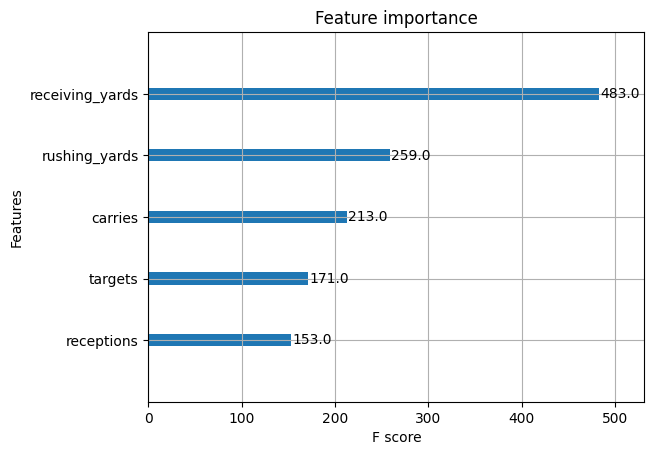

Feature Importance:
carries: 213.0
rushing_yards: 259.0
receptions: 153.0
targets: 171.0
receiving_yards: 483.0


In [12]:
# 1. Feature Importance
# XGBoost provides a way to access the importance of each feature in the model, which tells you how much each feature 
# contributes to the prediction.import matplotlib.pyplot as plt

# Plot feature importance
xgb.plot_importance(xgb_model)
plt.show()

# Alternatively, you can print the feature importance scores directly
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')
print("Feature Importance:")
for feature, importance in feature_importance.items():
    print(f"{feature}: {importance}")


In [15]:
# 2. Confusion Matrix
# A confusion matrix gives you a detailed breakdown of correct and incorrect predictions. It helps you understand where
# the model is making mistakes.

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Generate a detailed classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:")
print(class_report)


Confusion Matrix:
[[15132   690]
 [ 3465  1150]]
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     15822
           1       0.62      0.25      0.36      4615

    accuracy                           0.80     20437
   macro avg       0.72      0.60      0.62     20437
weighted avg       0.77      0.80      0.76     20437



In [19]:
# 3. Logloss Value
# To see the logloss value, which is the evaluation metric you've used, you can print the evaluation results during training.

# Initialize the model with eval_metric as a parameter
xgb_model = xgb.XGBClassifier(eval_metric="logloss")

# Define the evaluation set
eval_set = [(X_train, y_train), (X_test, y_test)]

# Train the model with evaluation monitoring
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=True)

# After training, you can access the evaluation results
evals_result = xgb_model.evals_result()

# Print the evaluation results
print("Evaluation Results:")
print(evals_result)

[0]	validation_0-logloss:0.48569	validation_1-logloss:0.49203
[1]	validation_0-logloss:0.46275	validation_1-logloss:0.47049
[2]	validation_0-logloss:0.44931	validation_1-logloss:0.45821
[3]	validation_0-logloss:0.44077	validation_1-logloss:0.45090
[4]	validation_0-logloss:0.43529	validation_1-logloss:0.44636
[5]	validation_0-logloss:0.43173	validation_1-logloss:0.44346
[6]	validation_0-logloss:0.42929	validation_1-logloss:0.44166
[7]	validation_0-logloss:0.42750	validation_1-logloss:0.44064
[8]	validation_0-logloss:0.42637	validation_1-logloss:0.43988
[9]	validation_0-logloss:0.42534	validation_1-logloss:0.43944
[10]	validation_0-logloss:0.42467	validation_1-logloss:0.43922
[11]	validation_0-logloss:0.42404	validation_1-logloss:0.43898
[12]	validation_0-logloss:0.42358	validation_1-logloss:0.43893
[13]	validation_0-logloss:0.42313	validation_1-logloss:0.43885
[14]	validation_0-logloss:0.42279	validation_1-logloss:0.43886
[15]	validation_0-logloss:0.42248	validation_1-logloss:0.43890
[1

In [11]:
# Adjust params ^

# Initialize the model with adjusted parameters
xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    # n_estimators=200,  # More boosting rounds
    # learning_rate=0.05,  # Smaller learning rate for better performance
    max_depth=4,  # Depth of the trees
    # subsample=0.8,  # Subsampling to reduce overfitting
    # colsample_bytree=0.8  # Feature subsampling
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model as before
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy:.4f}")


XGBoost Accuracy: 0.7967


In [34]:
# All together w/ Bayesian Inteference

def predict_touchdown_probability(player_name, opponent_defense_strength):
    # Connect to the database
    conn = sqlite3.connect('nfl.db')

    # Query to get historical data for the specific player using the correct column name
    query = f"""
    SELECT carries, rushing_yards, receptions, targets, receiving_yards
    FROM PlayerStats
    WHERE player_display_name = '{player_name}'
    """

    # Load the data into a DataFrame
    historical_data = pd.read_sql_query(query, conn)

    # Close the database connection
    conn.close()

    # Calculate prior distributions based on historical data
    carries_prior_mean = historical_data['carries'].mean()
    carries_prior_std = historical_data['carries'].std()

    rushing_yards_prior_mean = historical_data['rushing_yards'].mean()
    rushing_yards_prior_std = historical_data['rushing_yards'].std()

    receptions_prior_mean = historical_data['receptions'].mean()
    receptions_prior_std = historical_data['receptions'].std()

    targets_prior_mean = historical_data['targets'].mean()
    targets_prior_std = historical_data['targets'].std()

    receiving_yards_prior_mean = historical_data['receiving_yards'].mean()
    receiving_yards_prior_std = historical_data['receiving_yards'].std()

    # Create prior distributions
    carries_prior = norm(loc=carries_prior_mean, scale=carries_prior_std)
    rushing_yards_prior = norm(loc=rushing_yards_prior_mean, scale=rushing_yards_prior_std)
    receptions_prior = norm(loc=receptions_prior_mean, scale=receptions_prior_std)
    targets_prior = norm(loc=targets_prior_mean, scale=targets_prior_std)
    receiving_yards_prior = norm(loc=receiving_yards_prior_mean, scale=receiving_yards_prior_std)

    # Adjust the means based on the opponent's defense strength
    carries_likelihood_mean = carries_prior_mean * opponent_defense_strength
    rushing_yards_likelihood_mean = rushing_yards_prior_mean * opponent_defense_strength
    receptions_likelihood_mean = receptions_prior_mean * opponent_defense_strength
    targets_likelihood_mean = targets_prior_mean * opponent_defense_strength
    receiving_yards_likelihood_mean = receiving_yards_prior_mean * opponent_defense_strength

    # Combine prior and likelihood to get posterior estimates
    carries_posterior = (carries_prior.mean() + carries_likelihood_mean) / 2
    rushing_yards_posterior = (rushing_yards_prior.mean() + rushing_yards_likelihood_mean) / 2
    receptions_posterior = (receptions_prior.mean() + receptions_likelihood_mean) / 2
    targets_posterior = (targets_prior.mean() + targets_likelihood_mean) / 2
    receiving_yards_posterior = (receiving_yards_prior.mean() + receiving_yards_likelihood_mean) / 2

    # Create the player data based on the posterior estimates
    player_data = {
        'carries': [carries_posterior],
        'rushing_yards': [rushing_yards_posterior],
        'receptions': [receptions_posterior],
        'targets': [targets_posterior],
        'receiving_yards': [receiving_yards_posterior]
    }

    # Convert this data to a DataFrame
    player_df = pd.DataFrame(player_data)

    # Use the trained model to predict the probability of scoring a touchdown
    touchdown_probability = xgb_model.predict_proba(player_df)[:, 1]  # Probability of class 1 (scored a touchdown)

    # Print the result
    print(f"Probability of {player_name} scoring a touchdown: {touchdown_probability[0]:.4f}")

# Example usage:
# predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=0) # lower opponent_defense_strength better defense
# predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=1) # lower opponent_defense_strength better defense
predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=0.6) # lower opponent_defense_strength better defense

Probability of Travis Kelce scoring a touchdown: 0.2970


## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

conn = sqlite3.connect('nfl.db')
df = pd.read_sql_query("SELECT * FROM PlayerStats WHERE position IN ('RB', 'WR', 'TE');", conn)
conn.close()

# Combine rushing_tds and receiving_tds to create a binary outcome scored_touchdown (1 if the player scored a touchdown, 0 if not)
df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

features = ['carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards']
X = df[features]
y = df['scored_touchdown']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

Random Forest Accuracy: 0.7768


In [26]:
# w opponent defense

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load player data from the CSV file
df = pd.read_csv('PlayerStats.csv')

# Combine rushing_tds and receiving_tds to create a binary outcome scored_touchdown (1 if the player scored a touchdown, 0 if not)
df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Select features including opponent defense strength
features = ['carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']
X = df[features]
y = df['scored_touchdown']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")

# Function to predict touchdown probability
def predict_touchdown_probability(player_name, opponent_defense_strength):
    # Query the player's data from the CSV file
    player_data = df[df['player_display_name'] == player_name].copy()

    if player_data.empty:
        raise ValueError(f"No data found for player: {player_name}")

    # Add the provided opponent defense strength to the player's data
    player_data.loc[:, 'opponent_defense_strength'] = opponent_defense_strength

    # Prepare the data for prediction
    X_player = player_data[features]

    # Use the model to predict the probability
    probability = rf_model.predict_proba(X_player)[:, 1]  # Probability of scoring a touchdown

    # Print the result
    print(f"Probability of {player_name} scoring a touchdown against an opponent with defense strength {opponent_defense_strength}: {probability[0]:.4f}")

# Example usage:
predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=0.6)


Random Forest Accuracy: 0.7879
Probability of Travis Kelce scoring a touchdown against an opponent with defense strength 0.6: 0.1220


## Logistic Regression

In [11]:
# w/o opponent defense

import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Connect to the database and load data
conn = sqlite3.connect('nfl.db')
df = pd.read_sql_query("SELECT * FROM PlayerStats WHERE position IN ('RB', 'WR', 'TE');", conn)
conn.close()

# Create the target variable
df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Select features
features = ['carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards']
X = df[features]
y = df['scored_touchdown']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Function to predict touchdown probability
def predict_touchdown_probability(player_name, opponent_defense_strength):
    # Query the player's data from the database
    conn = sqlite3.connect('nfl.db')
    query = f"""
    SELECT carries, rushing_yards, receptions, targets, receiving_yards
    FROM PlayerStats
    WHERE player_display_name = '{player_name}'
    """
    player_data = pd.read_sql_query(query, conn)
    conn.close()

    if player_data.empty:
        raise ValueError(f"No data found for player: {player_name}")

    # Use the model to predict the probability
    X_player = player_data[features]
    probability = logreg_model.predict_proba(X_player)[:, 1]  # Probability of scoring a touchdown

    # Print the result
    print(f"Probability of {player_name} scoring a touchdown: {probability[0]:.4f}")

# Example usage:
predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=0.8)


Logistic Regression Accuracy: 0.7965
Probability of Travis Kelce scoring a touchdown: 0.2151


In [25]:
# w opponent defense

import pandas as pd
import sqlite3
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Connect to the database and load data
# conn = sqlite3.connect('nfl.db')
# df = pd.read_sql_query("SELECT * FROM PlayerStats WHERE position IN ('RB', 'WR', 'TE');", conn)
# conn.close()
df = pd.read_csv('PlayerStats.csv')

# Create the target variable
df['scored_touchdown'] = df[['rushing_tds', 'receiving_tds']].sum(axis=1).apply(lambda x: 1 if x > 0 else 0)

# Select features including opponent defense strength
features = ['carries', 'rushing_yards', 'receptions', 'targets', 'receiving_yards', 'opponent_defense_strength']
X = df[features]
y = df['scored_touchdown']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Evaluate the model
y_pred = logreg_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy:.4f}")

# Function to predict touchdown probability
def predict_touchdown_probability(player_name, opponent_defense_strength):
    # Query the player's data from the CSV file
    player_data = df[df['player_display_name'] == player_name].copy()

    if player_data.empty:
        raise ValueError(f"No data found for player: {player_name}")

    # Add the provided opponent defense strength to the player's data
    player_data.loc[:, 'opponent_defense_strength'] = opponent_defense_strength

    # Prepare the data for prediction
    X_player = player_data[features]

    # Use the model to predict the probability
    probability = logreg_model.predict_proba(X_player)[:, 1]  # Probability of scoring a touchdown

    # Print the result
    print(f"Probability of {player_name} scoring a touchdown against an opponent with defense strength {opponent_defense_strength}: {probability[0]:.4f}")

# Example usage:
predict_touchdown_probability(player_name="Travis Kelce", opponent_defense_strength=0.33)

Logistic Regression Accuracy: 0.8183
Probability of Travis Kelce scoring a touchdown against an opponent with defense strength 0.33: 0.2140
